## Assigment 2 Data Mining

Your task is to predict what hotel properties that result from a search of a user, the user is
most likely to click on.


The core task is "to predict what hotel a user is most likely to book"

**OUTCOME VARIABLE** is a combination of:

- `click_bool`: Whether the user clicked on that specific property (1=yes, 0=no).
- `booking_bool`: Whether the user booked that specific property (1=yes, 0=no).


**Evaluation Metric** (NDCG@5)
- Relevance 5: User booked the hotel (`booking_bool = 1`).
- Relevance 1: User clicked but did not book (`click_bool = 1` AND `booking_bool = 0`).
- Relevance 0: User neither clicked nor booked (`click_bool = 0` AND `booking_bool = 0`).

VIEW TOP RESULTS:
https://www.kaggle.com/competitions/expedia-personalized-sort/overview

FOLLOW-ALLONG KAGGLE TUTORIAL FOR A DESCENT SUBMISSION:
https://www.dataquest.io/blog/kaggle-tutorial/
https://www.studeersnel.nl/nl/document/vrije-universiteit-amsterdam/data-mining-techniques/expedia-assignment/95305972 old submission vu

**TODO**: 
- DESCRIBE TOP 5 SOLUTIONS
- Describe more recent submissions outside the competition

Each line in the dataset represents a combination of a search query by a user with one specific
hotel property that was shown as part of the results. 
Of course, a list of hotels is presented to the user (and hence, there are multiple rules describing a single search).


In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


project_root = Path('/Users/moisempongo/Documents/uni-projects/hotel-estimation/')
plot_dir = project_root / 'notebooks/plots'
colour_vu_blue_2 = '#5dadd0'

In [2]:
hotel_train = pd.read_csv(project_root / 'data/raw/training_set_VU_DM.csv')
hotel_test = pd.read_csv(project_root / 'data/raw/test_set_VU_DM.csv')

hotel_train['date_time'] = pd.to_datetime(hotel_train['date_time'])
hotel_test['date_time'] = pd.to_datetime(hotel_test['date_time'])

Creating random subset of the data for quicker training etc.

In [3]:
pct = 0.05

def gen_random_subset(df, pct=pct):
    np.random.seed(123)
    unique_srch_ids = df['srch_id'].drop_duplicates()
    random_array = np.random.choice(unique_srch_ids, size=int(pct*unique_srch_ids.shape[0]), replace=False)
    df_subset = df[df['srch_id'].isin(random_array)].copy()
    
    return df_subset

hotel_train_subset = gen_random_subset(hotel_train)
hotel_test_subset = gen_random_subset(hotel_test)

hotel_train_subset.to_csv(project_root / f'data/raw/subset_train_pct{pct}_set_VU_DM.csv', index=False)
hotel_test_subset.to_csv(project_root / f'data/raw/subset_test_pct{pct}_set_VU_DM.csv', index=False)

In [4]:
print('unique search ids train:', hotel_train[['srch_id']].drop_duplicates().count().values)
print('unique search ids test:', hotel_test[['srch_id']].drop_duplicates().count().values)
#hotel_test.dtypes.to_frame('dtypes features')
#hotel_train.columns

unique search ids train: [199795]
unique search ids test: [199549]


Users can have clicked on many hotels within the same search max = 25, the max number of hotels booked within a search is 1.

In [5]:
print(hotel_train[['srch_id','click_bool', 'booking_bool']].groupby('srch_id').sum().max())
hotel_train[['srch_id','click_bool', 'booking_bool']].groupby('srch_id').sum().sort_values(['click_bool'], ascending=False) #.sum(['click_book', 'booking_bool']).max()

click_bool      25
booking_bool     1
dtype: int64


,click_bool,booking_bool
srch_id,,
53860,25,0
14059,24,1
16260,20,1
309341,20,1
2247,19,0
...,...,...
114954,1,0
114956,1,0
114957,1,1


## Missing value analysis

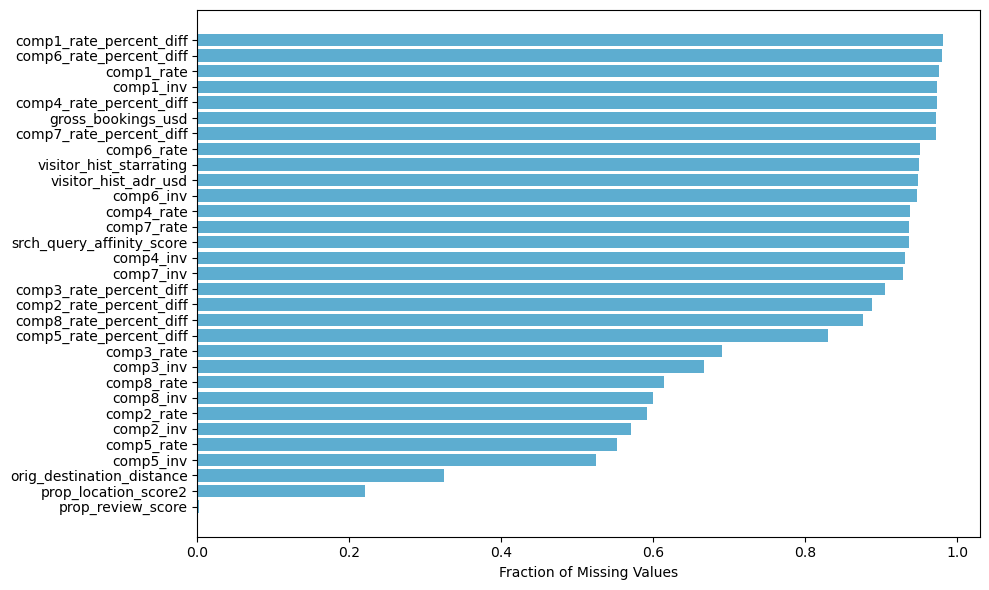

In [6]:
missing = hotel_train.isnull().mean().sort_values(ascending=False).to_frame('missing_fraction')
missing

# Barplot for missing values per feature
plt.figure(figsize=(10, 6))
missing_sorted = missing[missing['missing_fraction'] != 0].sort_values('missing_fraction', ascending=False)
plt.barh(missing_sorted.index, missing_sorted['missing_fraction'], color=colour_vu_blue_2)
plt.xlabel('Fraction of Missing Values')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(plot_dir / 'missing_value_fraction_per_feature.png')
plt.show()


Create training set for testing purposes uses XXX% of the data

In [7]:
# Create the relevance grade
hotel_train['relevance_grade'] = np.where(hotel_train['booking_bool'] == 1, 5, np.where(hotel_train['click_bool'] == 1, 1, 0))
print(hotel_train['relevance_grade'].value_counts().sort_index())

relevance_grade
0    4736468
1      83489
5     138390
Name: count, dtype: int64


## N hotels per query

      hotels_per_query
0.00               5.0
0.25              18.0
0.50              29.0
0.75              32.0
1.00              38.0
Histogram of Hotels per Query


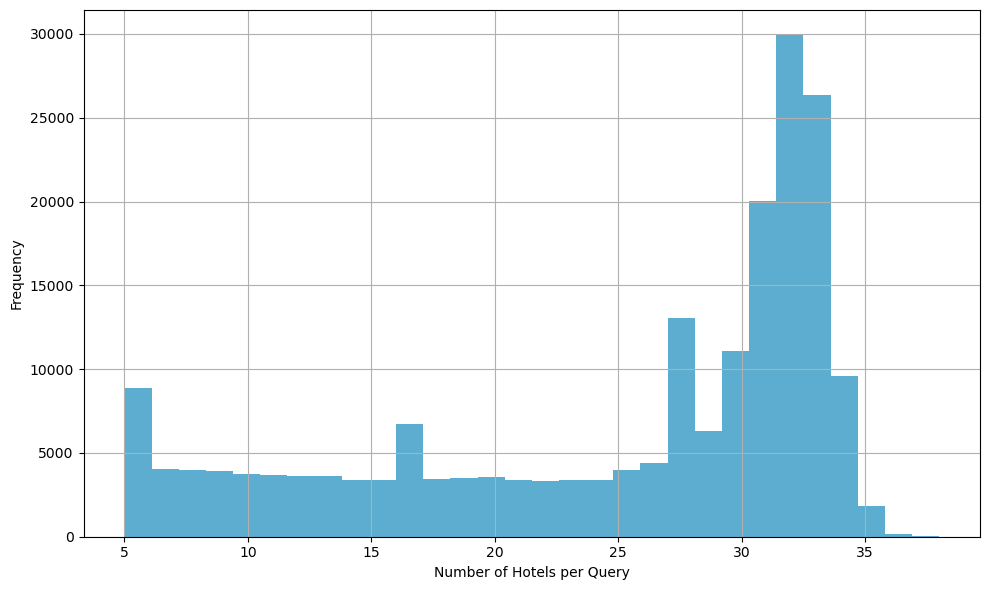

In [8]:
hotels_per_query = hotel_train.groupby('srch_id').size()
quantiles = hotels_per_query.quantile([0, .25, .5, .75, 1]).to_frame('hotels_per_query')
print(quantiles)

print('Histogram of Hotels per Query')
plt.figure(figsize=(10,6))
hotels_per_query.hist(bins=30, color = colour_vu_blue_2)
plt.xlabel('Number of Hotels per Query')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(plot_dir / 'histogram_hotels_per_query.png')
plt.show()

Summary statistic for numeric features

In [9]:
hotel_train.describe().T

,count,mean,min,25%,50%,75%,max,std
srch_id,4958347.0,166366.561096,1.0,82936.0,166507.0,249724.0,332785.0,96112.230102
date_time,4958347,2013-03-11 06:19:37.890842880,2012-11-01 00:08:29,2013-01-14 17:47:32,2013-03-13 20:13:18,2013-05-10 00:01:38,2013-06-30 23:58:24,NaN
site_id,4958347.0,9.953133,1.0,5.0,5.0,14.0,34.0,7.64689
visitor_location_country_id,4958347.0,175.340453,1.0,100.0,219.0,219.0,231.0,65.916249
visitor_hist_starrating,251866.0,3.374334,1.41,2.92,3.45,3.93,5.0,0.692519
visitor_hist_adr_usd,252988.0,176.022659,0.0,109.81,152.24,213.49,1958.7,107.254493
prop_country_id,4958347.0,173.973897,1.0,100.0,219.0,219.0,230.0,68.345248
prop_id,4958347.0,70079.179496,1.0,35010.0,69638.0,105168.0,140821.0,40609.920378
prop_starrating,4958347.0,3.180525,0.0,3.0,3.0,4.0,5.0,1.051024
prop_review_score,4950983.0,3.777777,0.0,3.5,4.0,4.5,5.0,1.050329


Correlation of variables with grade

                     feature  correlation
0       prop_location_score2     0.070919
1                random_bool    -0.069051
2             promotion_flag     0.038404
3  srch_query_affinity_score     0.029747
4          prop_review_score     0.026291
5            prop_starrating     0.024481
6                 comp8_rate     0.024419
7                 comp5_rate     0.021775
8                 comp4_rate     0.018805
9        srch_length_of_stay    -0.018702


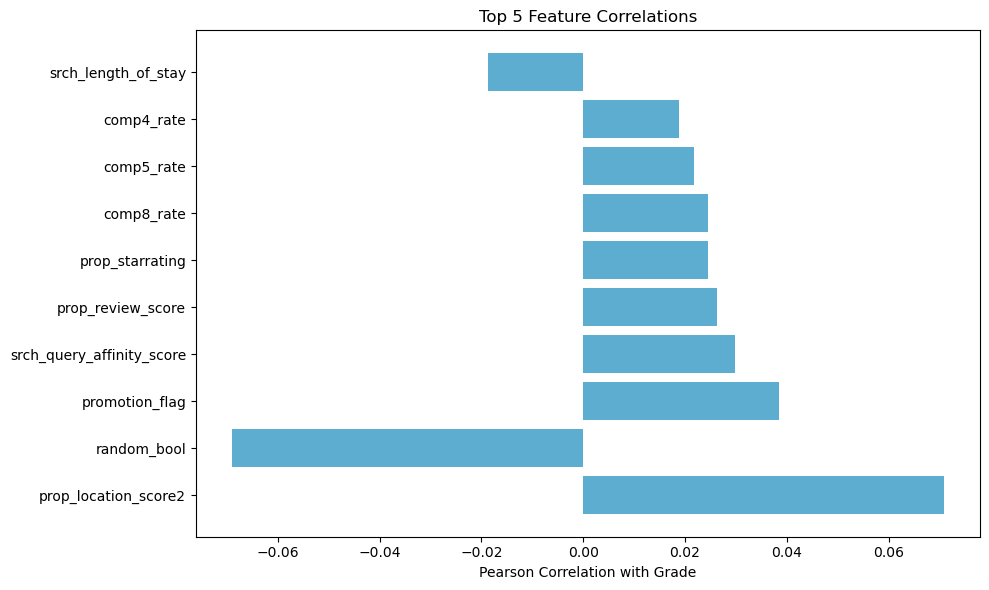

In [10]:
corr = hotel_train.corr()['relevance_grade'].drop(['relevance_grade','click_bool','booking_bool','gross_bookings_usd','position'])
top_corr = corr.abs().sort_values(ascending=False).head(10).index
top_corr_df = corr.loc[top_corr].to_frame('correlation').reset_index().rename(columns={'index':'feature'})
print(top_corr_df)

plt.figure(figsize=(10,6))
plt.barh(top_corr_df['feature'], top_corr_df['correlation'], color =colour_vu_blue_2)
plt.xlabel('Pearson Correlation with Grade')
plt.title('Top 5 Feature Correlations')
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/30/qx8v4whn3pq89wqsdtzjg5sh0000gn/T/ipykernel_6235/3973257942.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


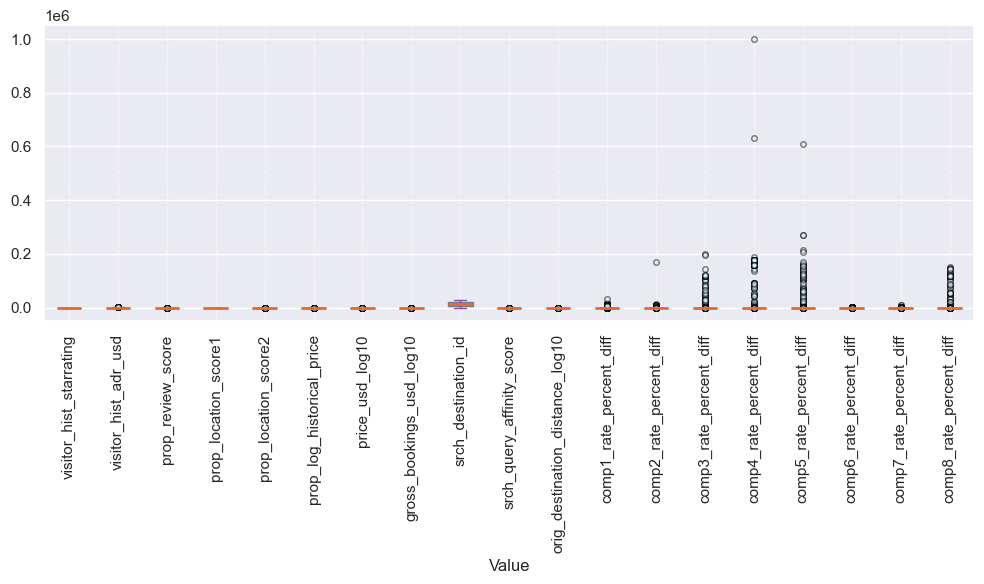

In [11]:
# BOXPLOTS

# Featues of interest
hotel_train['gross_bookings_usd_log10'] = np.log10(hotel_train['gross_bookings_usd'])
hotel_train['price_usd_log10'] = np.log10(hotel_train['price_usd'])
hotel_train['orig_destination_distance_log10'] = np.log10(hotel_train['orig_destination_distance'])

sns.set(font_scale=1.0)
float_features = [
    "visitor_hist_starrating",
    "visitor_hist_adr_usd",
    "prop_review_score",
    "prop_location_score1",
    "prop_location_score2",
    "prop_log_historical_price",
    "price_usd_log10",
    "gross_bookings_usd_log10", #typo in description on kaggle 
    "srch_destination_id",
    "srch_query_affinity_score",
    "orig_destination_distance_log10",
    "comp1_rate_percent_diff",
    "comp2_rate_percent_diff",
    "comp3_rate_percent_diff",
    "comp4_rate_percent_diff",
    "comp5_rate_percent_diff",
    "comp6_rate_percent_diff",
    "comp7_rate_percent_diff",
    "comp8_rate_percent_diff"
]
# Prepare data for boxplot (drop NaNs)
data = [hotel_train[feat].dropna() for feat in float_features]

plt.figure(figsize=(10, 6))
box = plt.boxplot(
    data,
    vert=True,
    labels=float_features,
    patch_artist=True,
    boxprops=dict(facecolor='#5dadd0', color='#2c3e50', alpha=0.6),
    medianprops=dict(color='#e8692d', linewidth=2),
    whiskerprops=dict(color='#8e4da4'),
    capprops=dict(color='#8e4da4'),
    flierprops=dict(marker='o', markerfacecolor='#d4effa', markersize=4, alpha=0.5),
)
plt.xlabel('Value')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(plot_dir / 'boxplot_selected_features.png')
plt.show()


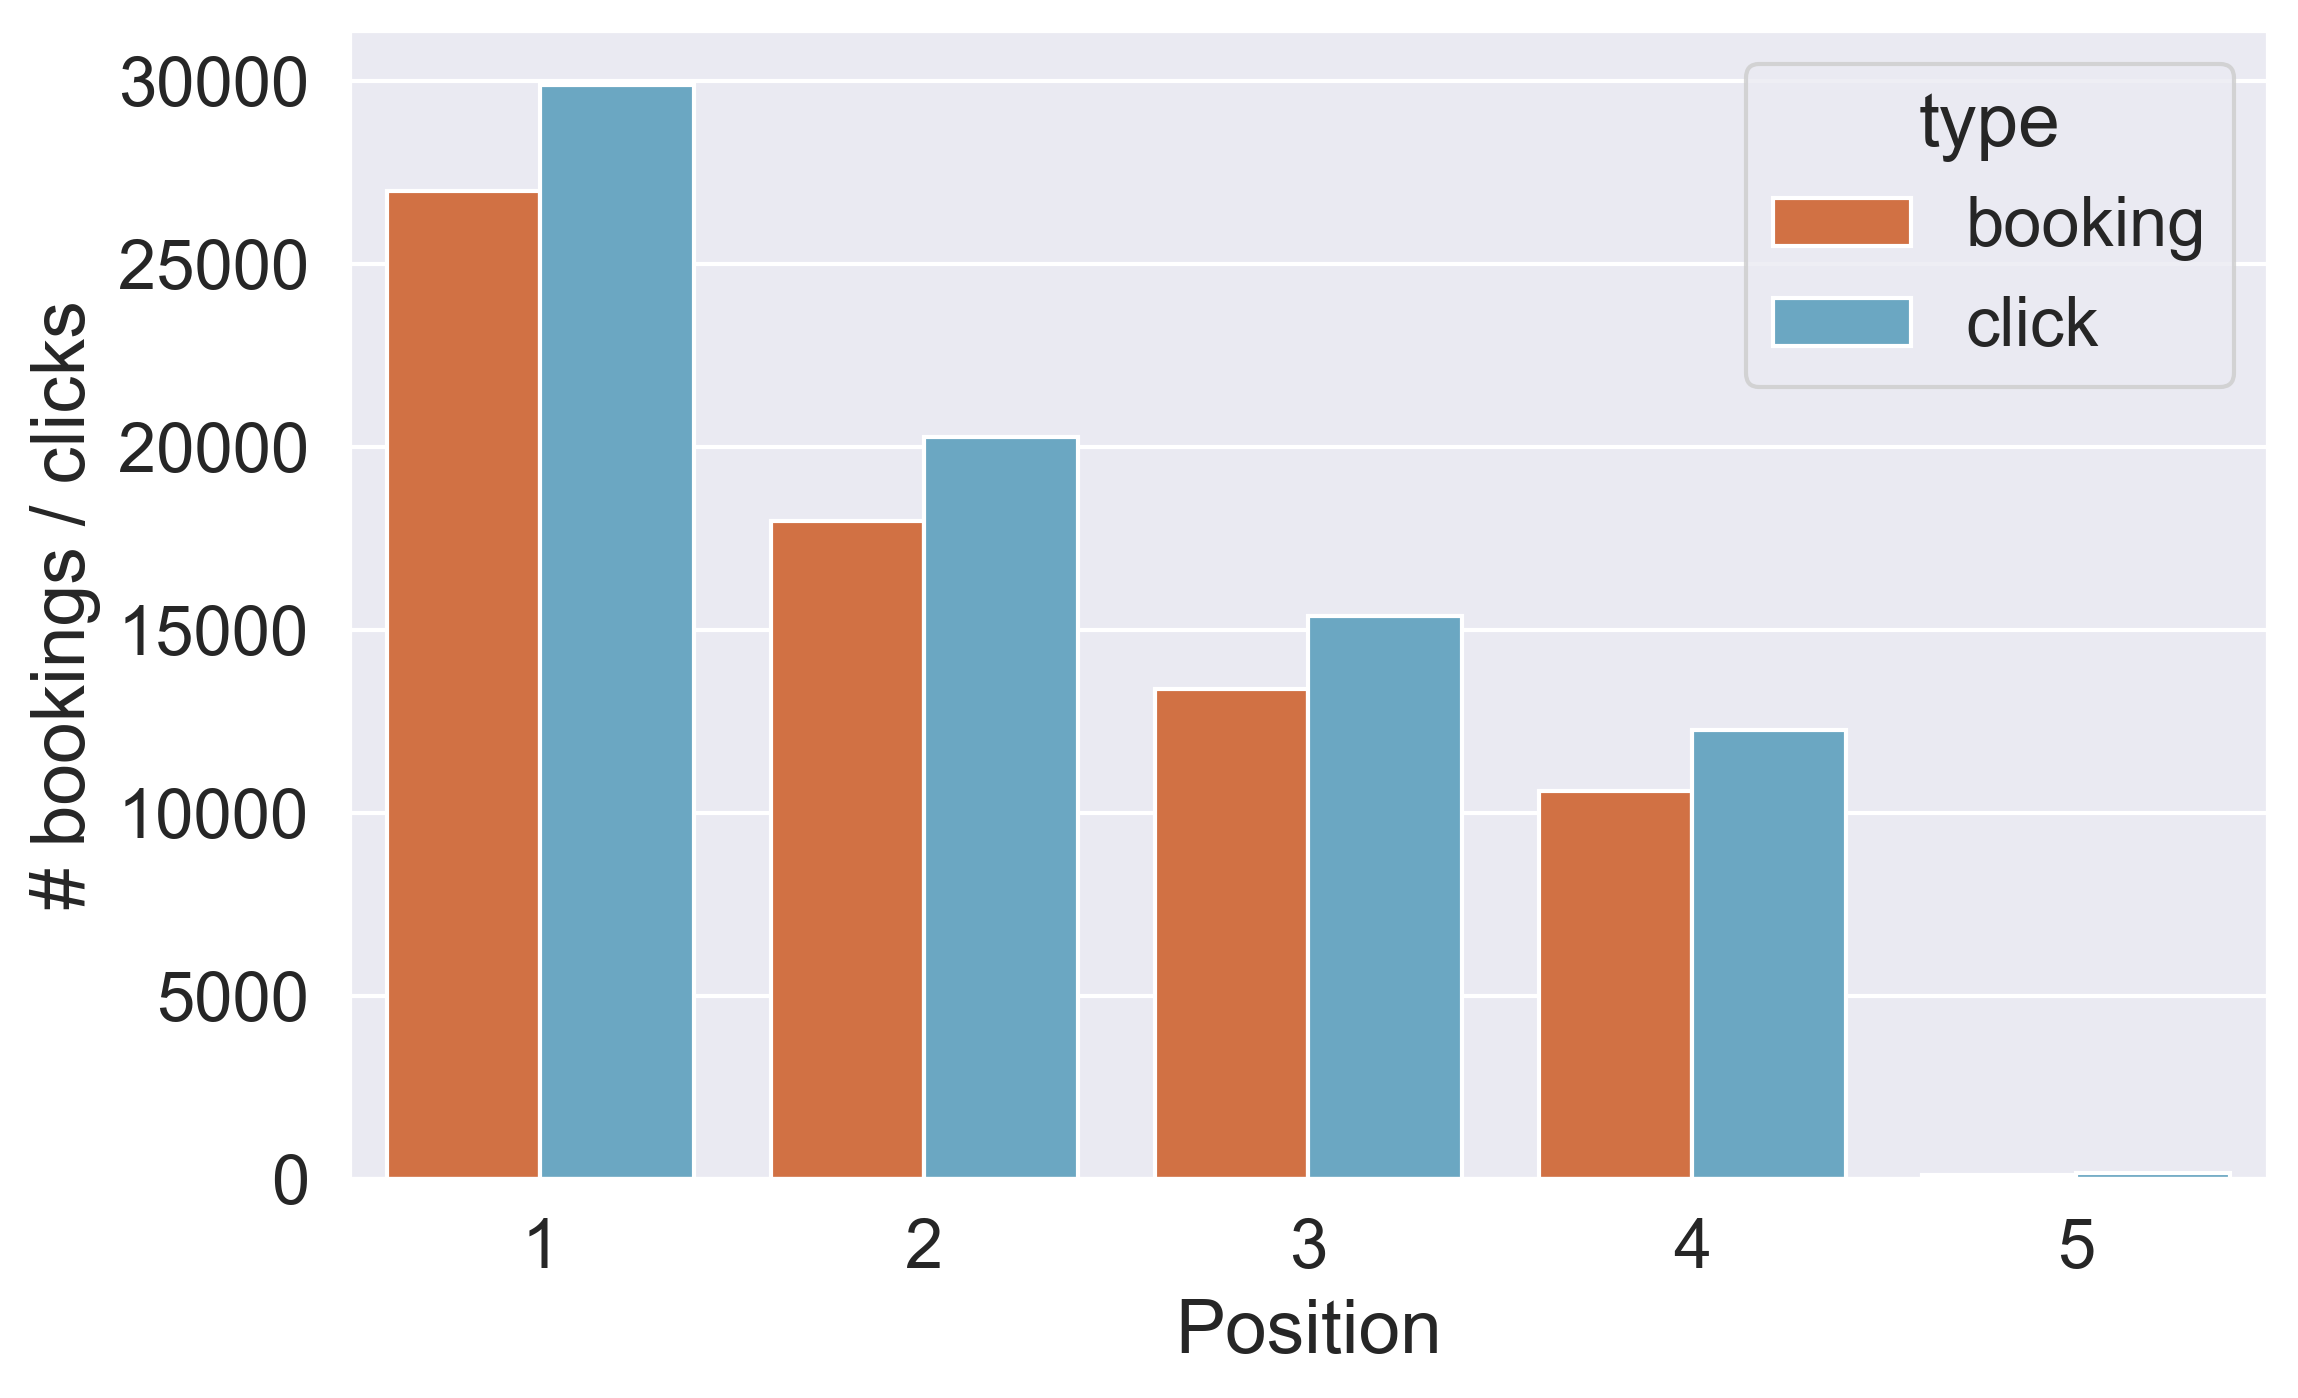

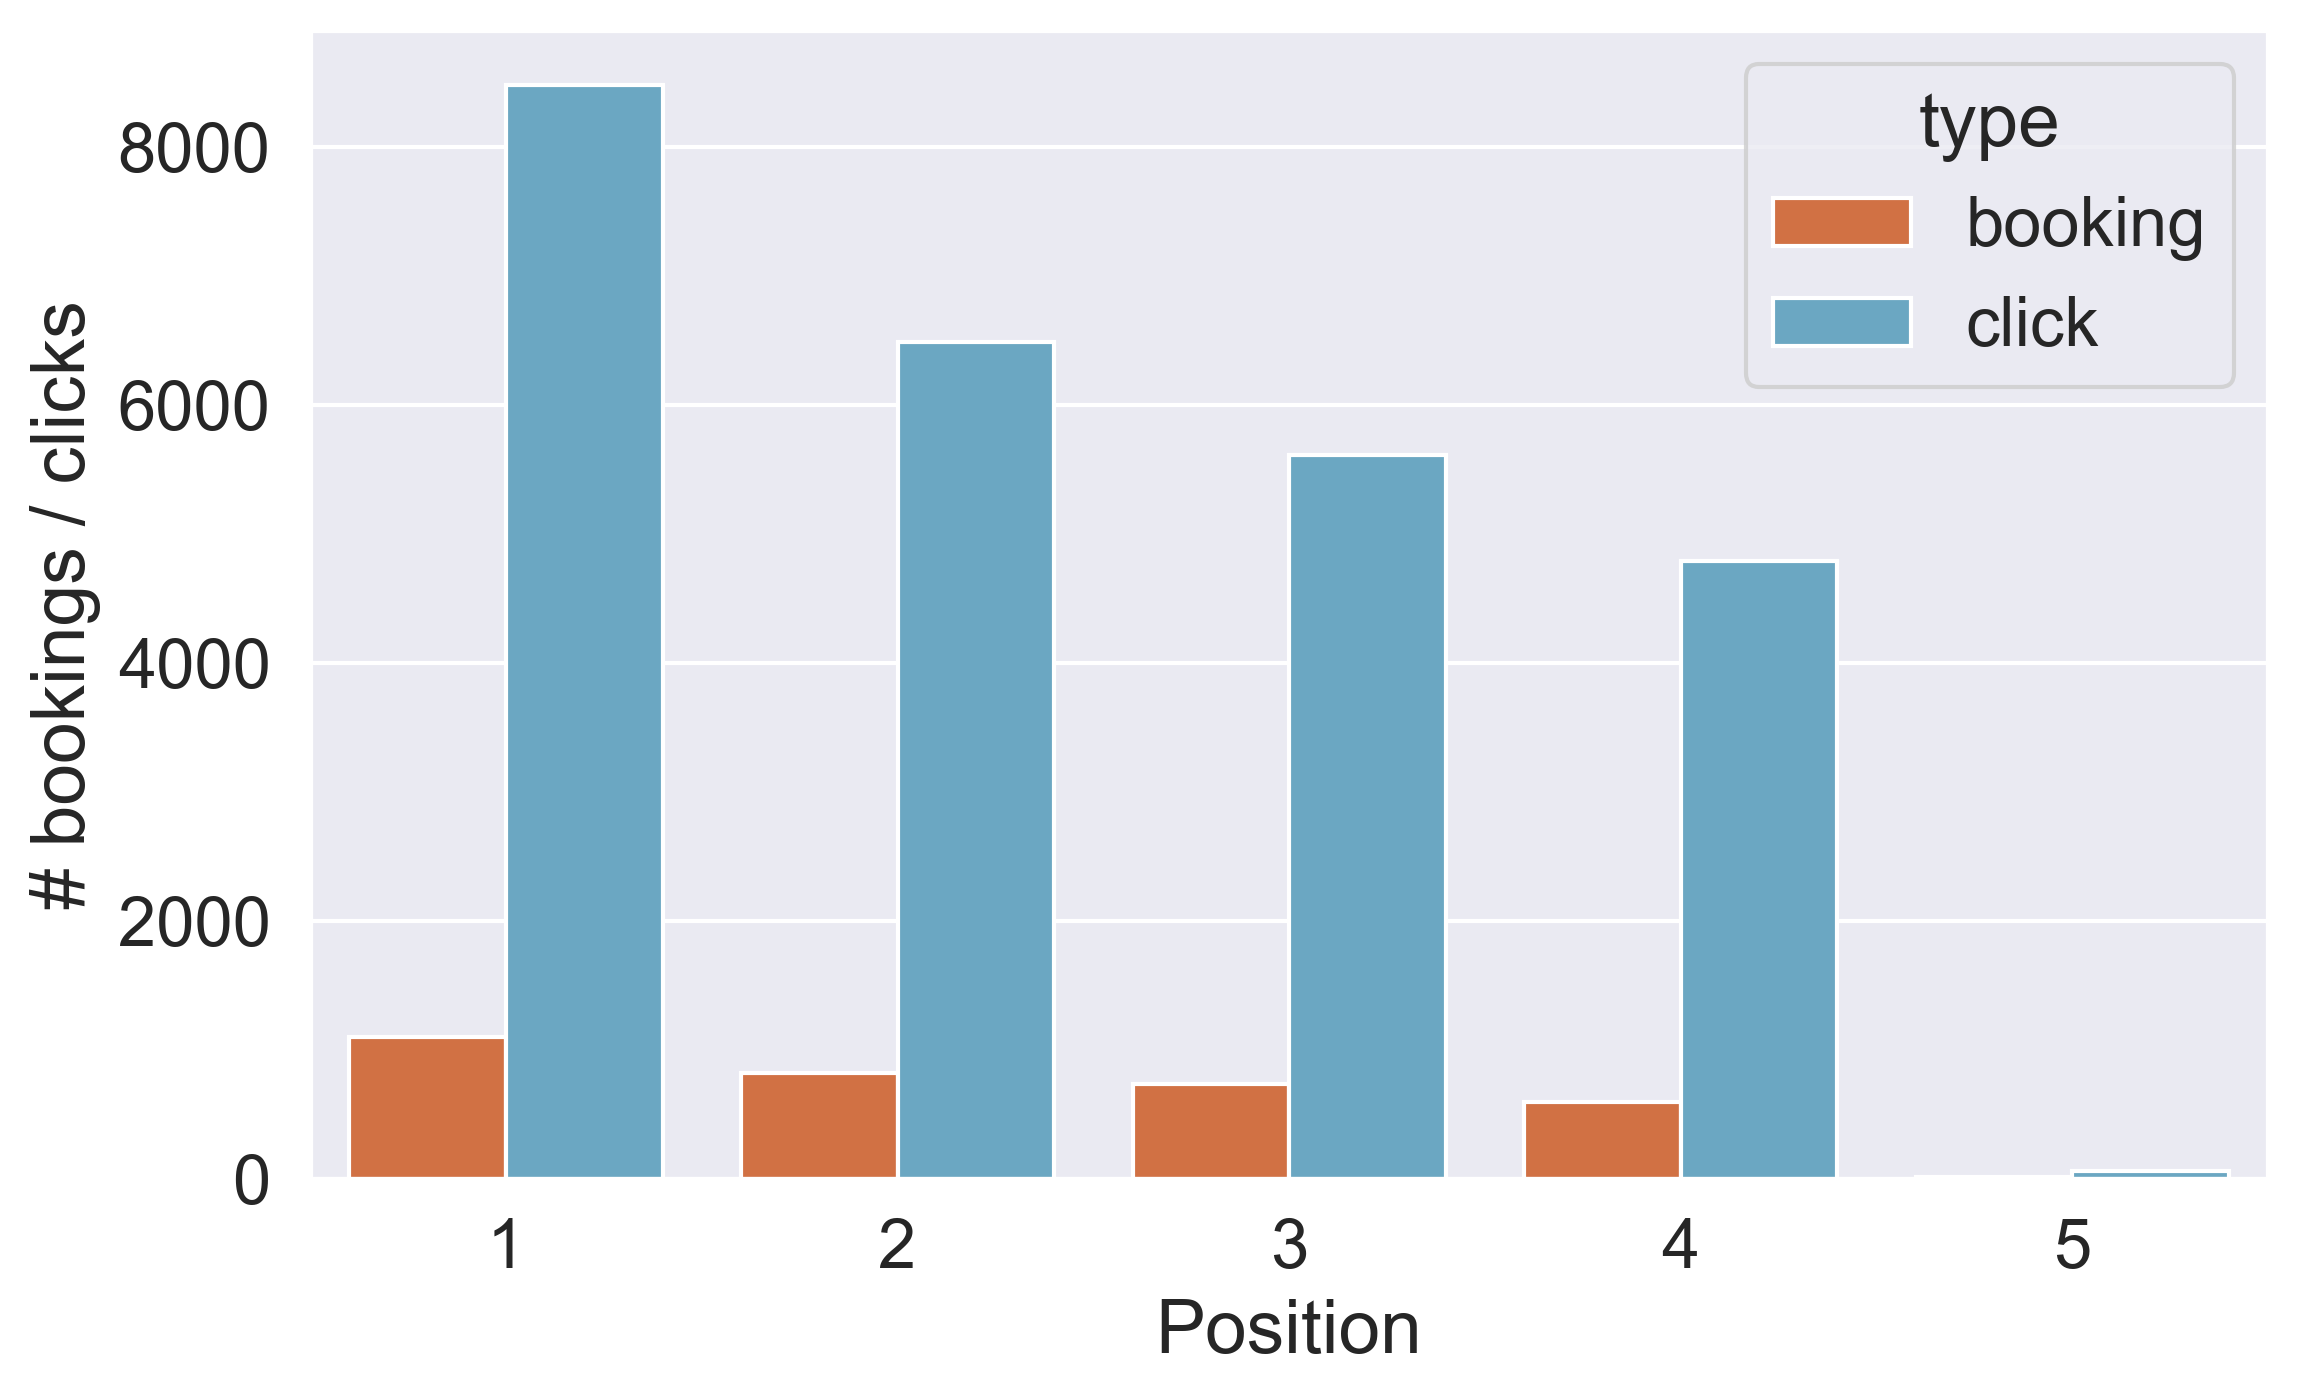

In [14]:
# Aggregate bookings and clicks by position and random_bool, then melt to long format
agg = hotel_train.groupby(['position', 'random_bool'])[['booking_bool', 'click_bool']].sum().reset_index()
summary = agg.melt(
    id_vars=['position', 'random_bool'],
    value_vars=['booking_bool', 'click_bool'],
    var_name='type',
    value_name='n'
)
summary['type'] = summary['type'].map({'booking_bool': 'booking', 'click_bool': 'click'})

# Only keep top 5 positions
summary_top5 = summary[summary['position'] <= 5]

sns.set(font_scale=1.5)

# Plot for non-random impressions
plt.figure(figsize=(8, 5), dpi=300)
sns.barplot(
    data=summary_top5[summary_top5['random_bool'] == 0],
    x='position',
    y='n',
    hue='type',
    dodge=True,
    palette=['#e8692d', '#5dadd0']
)
plt.xlabel("Position")
plt.ylabel("# bookings / clicks")
plt.legend(title="type")
plt.tight_layout()
plt.savefig(plot_dir / 'n_booking_clicks_nonrandom_top5.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot for random impressions
plt.figure(figsize=(8, 5), dpi=300)
sns.barplot(
    data=summary_top5[summary_top5['random_bool'] == 1],
    x='position',
    y='n',
    hue='type',
    dodge=True,
    palette=['#e8692d', '#5dadd0']
)
plt.xlabel("Position")
plt.ylabel("# bookings / clicks")
plt.legend(title="type")
plt.tight_layout()
plt.savefig(plot_dir / 'n_booking_clicks_random_top5.png', dpi=300, bbox_inches='tight')
plt.show()

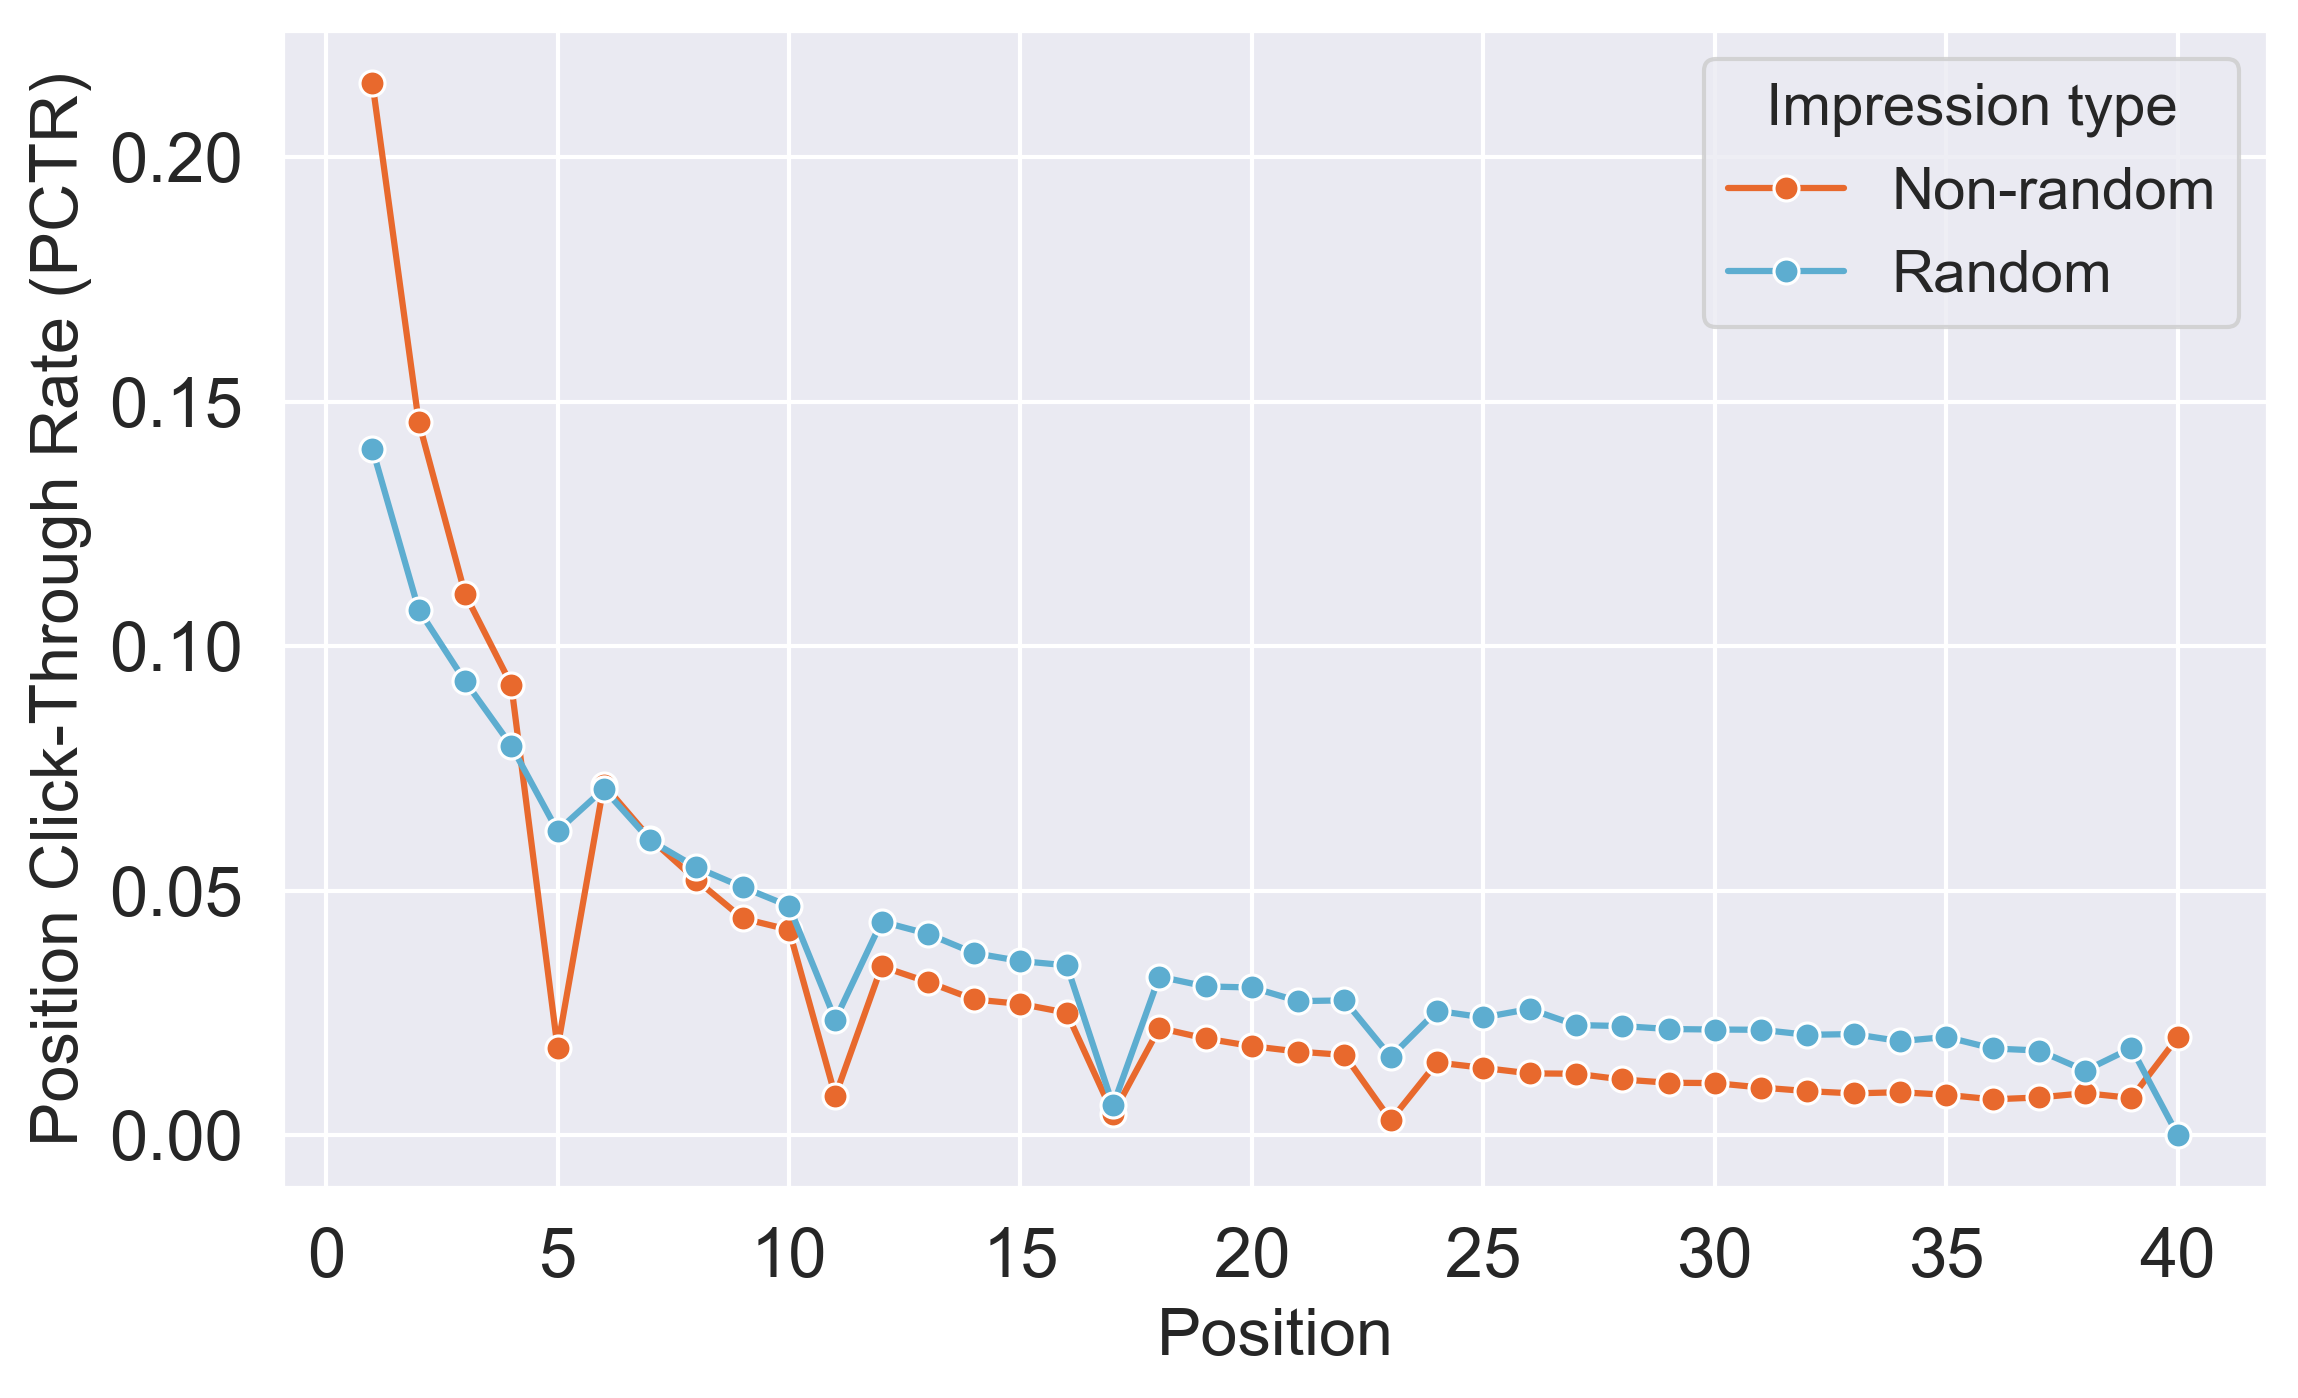

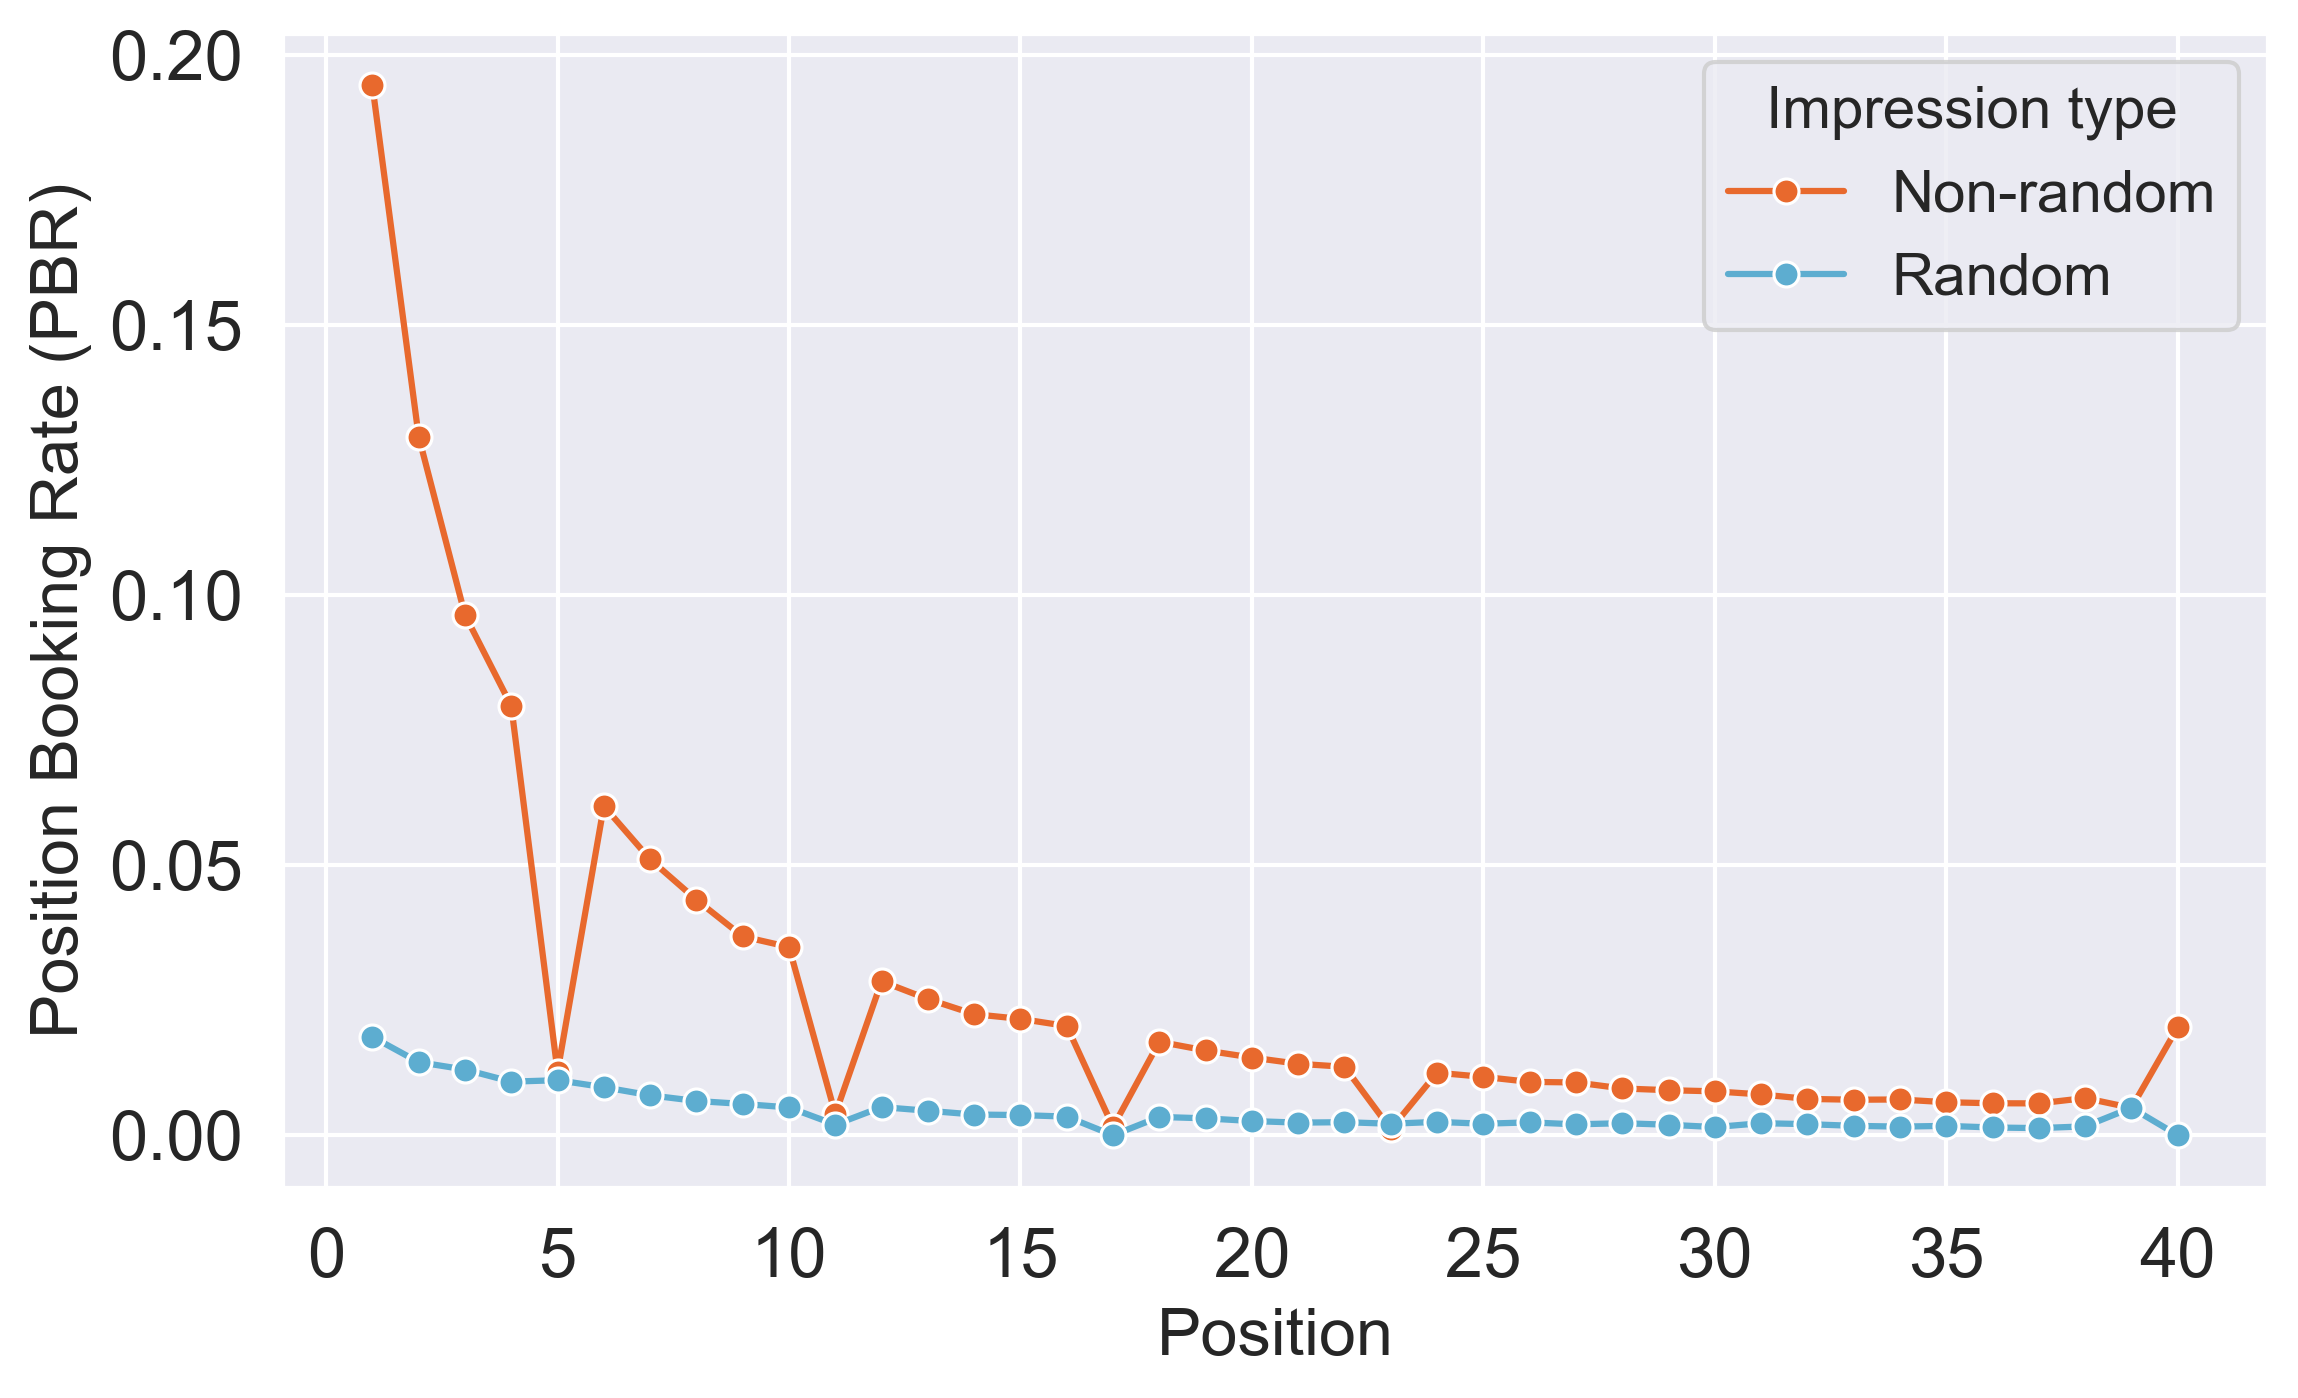

In [ ]:
# Plot PCTR curves
plt.figure(figsize=(8, 5), dpi=300)
ax = sns.lineplot(
    data=pctr,
    x='position',
    y='PCTR',
    hue='random_bool',
    hue_order=[0, 1],
    palette=['#e8692d', '#5dadd0'],
    marker='o'
)
plt.xlabel("Position", fontsize=16)
plt.ylabel("Position Click-Through Rate (PCTR)", footsie=16)
# Fix legend
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for l in labels:
    if l == "0":
        new_labels.append("Non-random")
    elif l == "1":
        new_labels.append("Random")
    elif l.lower().startswith("random"):
        new_labels.append("Impression type")
    else:
        new_labels.append(l)
ax.legend(handles=handles, labels=new_labels, title="Impression type", fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.savefig(plot_dir / 'pctr_by_position.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot PBR curves
plt.figure(figsize=(8, 5), dpi=300)
ax = sns.lineplot(
    data=pbr,
    x='position',
    y='PBR',
    hue='random_bool',
    hue_order=[0, 1],
    palette=['#e8692d', '#5dadd0'],
    marker='o'
)
plt.xlabel("Position", fontsize=16)
plt.ylabel("Position Booking Rate (PBR)", fontsize=16)
# Fix legend
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for l in labels:
    if l == "0":
        new_labels.append("Non-random")
    elif l == "1":
        new_labels.append("Random")
    elif l.lower().startswith("random"):
        new_labels.append("Impression type")
    else:
        new_labels.append(l)
ax.legend(handles=handles, labels=new_labels, title="Impression type", fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.savefig(plot_dir / 'pbr_by_position.png', dpi=300, bbox_inches='tight')
plt.show()